**Intro:**
The goal of this competition is to predict the survival rate of titanic passengers based on a dataset containing their gender, age, port of departure, etc.

**Best Score:**
900/13454, top ~7%

## 1. Importing Necessary Packages:

In [1]:
#importing initial packages
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt #graphing
import matplotlib.patches as mpatches #style
import seaborn as sns #advanced graphing
%matplotlib inline

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


## 2. Importing Data:

In [2]:
#importing the data
training = pd.read_csv("../input/titanic/train.csv")
testing = pd.read_csv("../input/titanic/test.csv")
training['train_test']=1
testing['train_test']=0
all_data=pd.concat([training,testing])

## 3. Discovering the Data:

In [3]:
#ensuring datatypes are correct
training.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
 12  train_test   891 non-null    int64  
dtypes: float64(2), int64(6), object(5)
memory usage: 90.6+ KB


In [4]:
#exploring descriptive statistics
training.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,train_test
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000,891.0
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208,1.0
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429,0.0
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000,1.0
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400,1.0
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200,1.0
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000,1.0
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200,1.0


**Observations:**
1. Not every person has an age.
2. Skewed towards lower ticket classes
3. Wide range in fares

## 4. Feature Engineering

In [5]:
#identifying the cabin type
training['Cabin_Type'] = training['Cabin'].apply(lambda x: str(x)[0])
training['Cabin_Type'].value_counts()

n    687
C     59
B     47
D     33
E     32
A     15
F     13
G      4
T      1
Name: Cabin_Type, dtype: int64

In [6]:
#identifying if a passenger has multiple cabins
training['Cabin'] = training['Cabin'].astype('string')
training.loc[training['Cabin'].str.contains(' ', na=0), 'Multiple_Cabins'] = 1
training.loc[training['Multiple_Cabins'] != 1, 'Multiple_Cabins'] = 0
training['Multiple_Cabins'].value_counts()

0.0    867
1.0     24
Name: Multiple_Cabins, dtype: int64

In [7]:
#identifying if a passenger has a letter before their ticket
training['Ticket_Letters']=training['Ticket'].apply(lambda x: 0 if x.isnumeric() else 1)
training['Ticket_Letters'].value_counts()

0    661
1    230
Name: Ticket_Letters, dtype: int64

In [8]:
#seperating a person's title from their name
training['Title'] = training['Name'].apply(lambda x: x.split(',')[1].split('.')[0])
training['Title'] = training['Title'].str.replace('Ms', 'Miss')
training['Title'] = training['Title'].str.replace('Mlle', 'Miss')
training['Title'] = training['Title'].str.replace('Mme', 'Mrs')
for title in ['Lady', 'Mlle', 'the Countess','Capt', 'Col', 'Mme', 'Don','Dr','Rev', 'Major', 'Sir', 'Jonkheer', 'Dona']:
    training['Title'] = training['Title'].str.replace(title, 'Misc')
training['Title'].value_counts()

 Mr        517
 Miss      185
 Mrs       126
 Master     40
 Misc       23
Name: Title, dtype: int64

## 5. Exploratory Analysis:

In [9]:
#seperating quantitative and qualitative variables
quant_var_list = ['Age','SibSp','Parch','Fare','Survived','PassengerId']
qual_var_list = ['Pclass','Sex','Embarked','Cabin_Type','Multiple_Cabins','Ticket_Letters','Title','Survived','PassengerId']
quant_var = training[quant_var_list]
qual_var = training[qual_var_list]
quant_var_list.remove('Survived')
quant_var_list.remove('PassengerId')
qual_var_list.remove('Survived')
qual_var_list.remove('PassengerId')

In [10]:
#helper functions
def easy_hist(i):
    plt.hist(quant_var[i])
    plt.title(i)
    plt.show()
    
def qual_stacked_bar(i):
    bar1=sns.barplot(y=qual_var[i].value_counts(),x=qual_var[i].value_counts().index,color='lightblue')
    bar2=sns.barplot(y=qual_var[qual_var['Survived']==True][i].value_counts(),x=qual_var[i].value_counts().index,color='darkblue')
    top_bar=mpatches.Patch(color='lightblue',label='Survived = No')
    bottom_bar=mpatches.Patch(color='darkblue',label='Survived = Yes')
    plt.legend(handles=[top_bar,bottom_bar])
    plt.show()
    
def survived_pivot_table(i):
    print(pd.crosstab(training['Survived'],training[i],normalize='columns'))
    print()

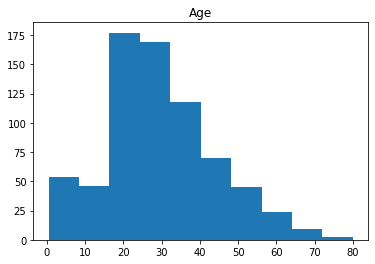

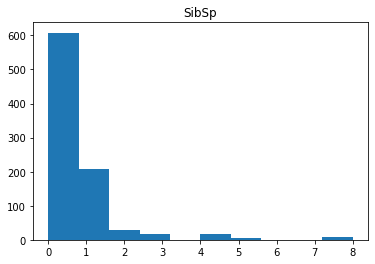

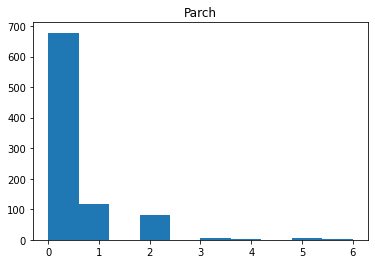

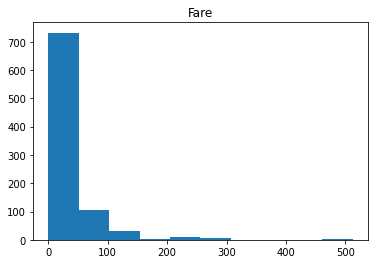

In [11]:
#looking at quantitative variable histograms
for i in quant_var_list:
    easy_hist(i)

**Observations:**

1. Not many children. Age count peaks around 20.
2. Mostly 0 siblings or spouses on board, drops off rapidly. A few outliers.
3. Mostly 0 parents or children on board, drops off rapidly. A few outliers.
4. Mostly cheap fares, drops off rapidly. Grand majority are below $100. A few outliers

                  Age     SibSp     Parch      Fare  Survived  PassengerId
Age          1.000000 -0.308247 -0.189119  0.096067 -0.077221     0.036847
SibSp       -0.308247  1.000000  0.414838  0.159651 -0.035322    -0.057527
Parch       -0.189119  0.414838  1.000000  0.216225  0.081629    -0.001652
Fare         0.096067  0.159651  0.216225  1.000000  0.257307     0.012658
Survived    -0.077221 -0.035322  0.081629  0.257307  1.000000    -0.005007
PassengerId  0.036847 -0.057527 -0.001652  0.012658 -0.005007     1.000000


<AxesSubplot:>

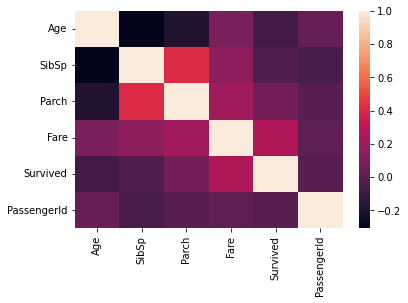

In [12]:
#looking for correlations between quantitative variables
quant_corr = quant_var.corr()
print(quant_corr)
sns.heatmap(quant_corr)

**Observations:**

1. The only correlation that is slightly of note is the .414838 correlation between number of siblings/spouses and mumber of parents/children. Maybe if someone is traveling with at least a few members of their family, they are more likely to have even more members.

In [13]:
#looking at quantitative averages for those who survive and those who do not
pd.pivot_table(training, index='Survived',values=quant_var_list)

,Age,Fare,Parch,SibSp
Survived,,,,
0,30.626179,22.117887,0.329690,0.553734
1,28.343690,48.395408,0.464912,0.473684


**Observations:**

1. Those who survived skew slightly younger (by ~2.3 years).
2. Those who survived paid, on average, more than double those who did not for their fare.
3. Those who survived tend to have more children/parents on board, but the difference is small.
4. Those who survived tend to have more spouses/siblings on board, but the difference is small.

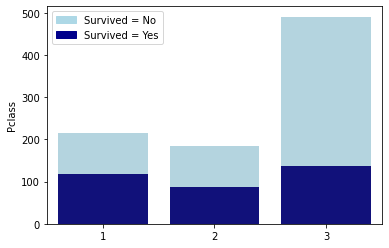

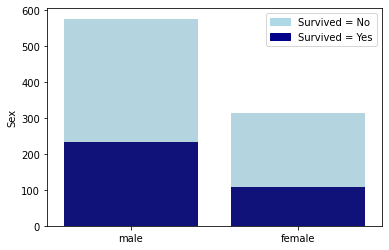

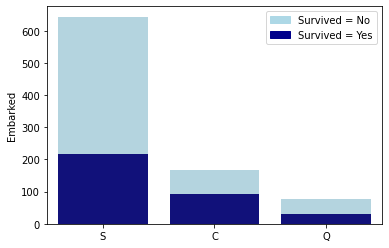

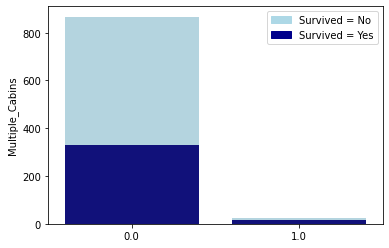

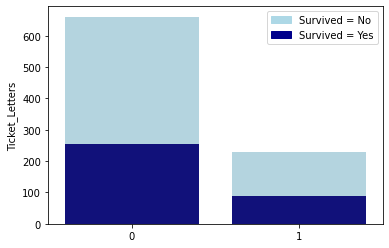

In [14]:
#looking at the survival numbers by qualitative attribute graphically
for i in ['Pclass','Sex','Embarked','Multiple_Cabins','Ticket_Letters']:
    qual_stacked_bar(i)

**Observations:**

1. More people survived than not.
2. Most people were in third class, more than double the first and second class (in order of respective size).
3. Almost twice as many males than females were on board.
4. Vast majority of people embarked at Southampton, followed by Cherbourg and Queenstown (respectively).

In [15]:
#looking at survival rate by qualitative attribute
for i in qual_var_list:
    survived_pivot_table(i)

Pclass          1         2         3
Survived                             
0         0.37037  0.527174  0.757637
1         0.62963  0.472826  0.242363

Sex         female      male
Survived                    
0         0.257962  0.811092
1         0.742038  0.188908

Embarked         C        Q         S
Survived                             
0         0.446429  0.61039  0.663043
1         0.553571  0.38961  0.336957

Cabin_Type         A         B        C         D     E         F    G    T  \
Survived                                                                      
0           0.533333  0.255319  0.40678  0.242424  0.25  0.384615  0.5  1.0   
1           0.466667  0.744681  0.59322  0.757576  0.75  0.615385  0.5  0.0   

Cabin_Type         n  
Survived              
0           0.700146  
1           0.299854  

Multiple_Cabins       0.0       1.0
Survived                           
0                0.621684  0.416667
1                0.378316  0.583333

Ticket_Letters        

**Observations:**

1. Those in first class were much more likely to survive than second and third class, respectively.
2. Females were much more likely to survive than males.
3. Guests who boarded at Cherbourg had the highest survival rate, followed by Queenstown, then Southhampton. Maybe those who boarded at each different place were predominantly wealthier or of a certain gender.
4. There are large differences in survival rate by cabin type, but because there are so few people who have their cabin type, this may not be very significant
5. If a ticket has a letter or not seems to have no bearing on survival rate, will drop when modeling
6. Survival rate varies wildly by title, but this may have to do with gender

## 6. Data Preprocessing

In [16]:
#re-doing feature engineering for all_data
#Cabin_Type
all_data['Cabin_Type'] = all_data['Cabin'].apply(lambda x: str(x)[0])
#Multiple_Cabins
all_data['Cabin'] = all_data['Cabin'].astype('string')
all_data.loc[all_data['Cabin'].str.contains(' ', na=0), 'Multiple_Cabins'] = 1
all_data.loc[all_data['Multiple_Cabins'] != 1, 'Multiple_Cabins'] = 0
#Ticket_Letters
all_data['Ticket_Letters']=all_data['Ticket'].apply(lambda x: 0 if x.isnumeric() else 1)
#Title
all_data['Title'] = all_data['Name'].apply(lambda x: x.split(',')[1].split('.')[0])
all_data['Title'] = all_data['Title'].str.replace('Ms', 'Miss')
all_data['Title'] = all_data['Title'].str.replace('Mlle', 'Miss')
all_data['Title'] = all_data['Title'].str.replace('Mme', 'Mrs')
for title in ['Lady', 'Rev', 'the Countess','Capt', 'Col', 'Dr', 'Don', 'Major', 'Sir', 'Jonkheer', 'Don']:
    all_data['Title'] = all_data['Title'].str.replace(title, 'Misc')
all_data['Title'] = all_data['Title'].str.replace('Misca', 'Misc')

In [17]:
#filling na values
all_data['Age'] = all_data['Age'].fillna(training['Age'].median())
all_data['Fare'] = all_data['Fare'].fillna(training['Fare'].median())
all_data['Embarked'] = all_data['Embarked'].fillna(training['Embarked'].mode())

In [18]:
#dropping columns without an 'embarked'
all_data.dropna(subset=['Embarked'],inplace=True)

In [19]:
#no missing values (that matter)
all_data.isna().sum()

PassengerId           0
Survived            418
Pclass                0
Name                  0
Sex                   0
Age                   0
SibSp                 0
Parch                 0
Ticket                0
Fare                  0
Cabin              1014
Embarked              0
train_test            0
Cabin_Type            0
Multiple_Cabins       0
Ticket_Letters        0
Title                 0
dtype: int64

In [20]:
print(pd.crosstab(all_data['Survived'],all_data['Cabin_Type'],normalize='columns'))

Cabin_Type         A         B        C         D     E         F    G    T  \
Survived                                                                      
0.0         0.533333  0.266667  0.40678  0.242424  0.25  0.384615  0.5  1.0   
1.0         0.466667  0.733333  0.59322  0.757576  0.75  0.615385  0.5  0.0   

Cabin_Type         n  
Survived              
0.0         0.700146  
1.0         0.299854  


In [21]:
#seperating useful features
useful_features = ['PassengerId','Survived','Pclass','Sex','Age','SibSp','Parch','Fare','Embarked','Cabin_Type',
                  'Multiple_Cabins','Title','train_test']

In [22]:
#getting dummies
useful_data_with_dummies=pd.get_dummies(all_data[useful_features])

In [23]:
#making sure the dummies look good
useful_data_with_dummies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1307 entries, 0 to 417
Data columns (total 28 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   PassengerId      1307 non-null   int64  
 1   Survived         889 non-null    float64
 2   Pclass           1307 non-null   int64  
 3   Age              1307 non-null   float64
 4   SibSp            1307 non-null   int64  
 5   Parch            1307 non-null   int64  
 6   Fare             1307 non-null   float64
 7   Multiple_Cabins  1307 non-null   float64
 8   train_test       1307 non-null   int64  
 9   Sex_female       1307 non-null   uint8  
 10  Sex_male         1307 non-null   uint8  
 11  Embarked_C       1307 non-null   uint8  
 12  Embarked_Q       1307 non-null   uint8  
 13  Embarked_S       1307 non-null   uint8  
 14  Cabin_Type_A     1307 non-null   uint8  
 15  Cabin_Type_B     1307 non-null   uint8  
 16  Cabin_Type_C     1307 non-null   uint8  
 17  Cabin_Type_D   

In [24]:
#re-seperating into train/test
#train
X_train = useful_data_with_dummies[useful_data_with_dummies['train_test']==1]
y_train = X_train['Survived']
X_train.drop(columns=['Survived'],inplace=True)
X_train.drop(columns=['train_test'],inplace=True)
#test
X_test = useful_data_with_dummies[useful_data_with_dummies['train_test']==0]
X_test.drop(columns=['Survived'],inplace=True)
X_test.drop(columns=['train_test'],inplace=True)

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


## 7. Modeling

In [25]:
#Helper functions
def initial_model(model):
    for i in [X_train,X_train_scaled]:
        mdl = model
        cv = cross_val_score(mdl,i,y_train,cv=5)
        print(cv)
        print(cv.mean())
        
def tuned_model(param_grid,model):
    mdl = GridSearchCV(model,param_grid = param_grid, n_jobs=3, verbose = 1)
    mdl.fit(X_train_scaled,y_train)
    print(mdl.best_score_)
    best=mdl.best_estimator_
    return best

In [26]:
#importing models
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier

In [27]:
#compiling list of models
models = [GaussianNB(), KNeighborsClassifier(),
          RandomForestClassifier(),SVC(),XGBClassifier()]

In [28]:
#scaling
scaler=StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

In [29]:
#testing the models
for i in models:
    print(i, ':')
    initial_model(i)

GaussianNB() :
[0.7752809  0.75280899 0.78089888 0.76404494 0.83050847]
0.780708436488288
[0.67977528 0.7247191  0.71910112 0.71348315 0.74576271]
0.71656827270996
KNeighborsClassifier() :
[0.62359551 0.45505618 0.47752809 0.47752809 0.68361582]
0.5434647368755158
[0.8258427  0.79775281 0.80898876 0.76404494 0.85310734]
0.8099473116231829
RandomForestClassifier() :
[0.76404494 0.79775281 0.86516854 0.79213483 0.84745763]
0.8133117501428299
[0.75842697 0.79775281 0.84831461 0.79213483 0.83615819]
0.8065574811147084
SVC() :
[0.61797753 0.64044944 0.64606742 0.64044944 0.65536723]
0.6400622103726274
[0.81460674 0.80898876 0.81460674 0.78651685 0.85310734]
0.8155652891512728
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=No

In [30]:
#creating param grids
svc_param_grid = {'C': [0.1, 1, 10, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']}
rf_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}
mlp_param_grid = {'hidden_layer_sizes': [(10,30,10),(20,)],
                'activation': ['tanh', 'relu'],
                'solver': ['sgd', 'adam'],
                'alpha': [0.0001, 0.05],
                'learning_rate': ['constant','adaptive'],
}

In [31]:
#svc
#svc=tuned_model(svc_param_grid, SVC())

In [32]:
#rf
rf=tuned_model(rf_param_grid,RandomForestClassifier())

Fitting 5 folds for each of 54 candidates, totalling 270 fits
0.8301910747159271


In [33]:
#MLP
#mlp=tuned_model(mlp_param_grid,MLPClassifier(max_iter=60))

## 8. Final Model Preparation

In [34]:
#the tuned rf model had the best cv results, so I am using it to predict the test data
y_test = rf.predict(X_test_scaled)

In [35]:
y_test = y_test.astype(int)

In [36]:
final_data = {'PassengerId': testing.PassengerId, 'Survived': y_test}
submission = pd.DataFrame(data=final_data)

In [37]:
submission.to_csv('submission_rf_tuned.csv', index=False)

**References:**

Huge thank you to the creators of these notebooks which I used for guidance and inspiration

https://www.kaggle.com/code/kenjee/titanic-project-example

https://www.kaggle.com/code/odaymourad/detailed-and-typical-solution-ensemble-modeling